# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  WL2522
* Name: Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

First, rows with no comments or duplicate rows that have the same combination of request type and comment are removed. Rows with  comments that are less than 12 characters long were also removed due to comments of that length not being too informative.


Then, embedded image tags are removed from the categories.

Having removed the embedded image tags from the categories, the following categories are consolidated due to them having the same meaning with different wordings:


1. "bike facilities don't exist or need improvement" / "there are no bike facilities or they need maintenance"

2. "sidewalks/ramps don't exist or need improvement" / "there are no sidewalks or they need maintenance"

3. "the wait for the "Walk" signal is too long" / "people have to wait too long for the "Walk" signal"

4. "the roadway surface needs improvement" / "the roadway surface needs maintenance"

5. "it’s hard to see / low visibility" / "it’s hard for people to see each other"

6. "it's too far / too many lanes to cross" / "people have to cross too many lanes / too far"

7. "people are not given enough time to cross the street" / "there's not enough time to cross the street"

The following categories are very similar to each other, but not quite the same, and thus were not combined during this preprocessing step:


>"people don't yield while going straight" / "people don't yield while turning" /  "people run red lights / stop signs"


Whenever categories are consolidated, I merge the category with fewer data points into the one with more data points.


In [143]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import gensim

from scipy.sparse import hstack
from collections import Counter
from gensim import corpora, models

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, adjusted_rand_score
from sklearn.preprocessing import Normalizer, MaxAbsScaler

from sklearn.pipeline import make_pipeline, make_union

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation

data = pd.read_csv('Vision_Zero_Entry.csv')


["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'people double park their vehicles'
 'the wait for the "Walk" signal is too long' "sidewalks/ramps don't exist or need improvement"
 'people speed' 'people cross away from the crosswalks'
 "there's not enough time to cross the street" "it's too far / too many lanes to cross"
 'people run red lights / stop signs' 'the roadway surface needs improvement'
 'there are no bike facilities or they need maintenance' 'the roadway surface needs maintenance'
 'people have to cross too many lanes / too far' 'there are no sidewalks or they need maintenance'
 'people have to wait too long for the "Walk" signal' 'it’s hard for people to see each other'
 'people are not given enough time to cross the street'
 '" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility'
 '" src=

([<matplotlib.axis.YTick at 0x267245f0908>,
 <a list of 28 Text yticklabel objects>)

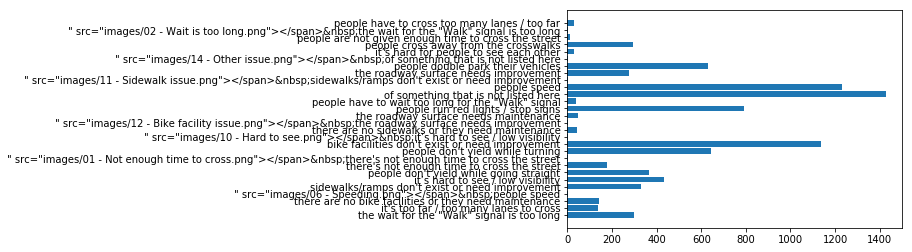

In [99]:
#Visualize the distribution of the categories


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [100]:
#Remove rows with no comments
#Remove duplicate rows that have the same category and comment
#Remove rows with comments that are less than 12 characters long
#Create a list of categories
#Consolidate the categories that have embedded images tags into corresponding categories


data = data[data['COMMENTS'].notnull()]
data = data.drop_duplicates(subset=['REQUESTTYPE', 'COMMENTS'])
data = data[data['COMMENTS'].str.len() > 12]


print(len(data['REQUESTTYPE'].unique()))
categories = data['REQUESTTYPE'].unique()
categories = categories.tolist()
categories.sort()

for a in range(len(categories)): print(categories[a])
    
data['REQUESTTYPE'].replace(to_replace=categories[0:7], value=[
        "there's not enough time to cross the street",
    'the wait for the "Walk" signal is too long',
    'people speed', 'it’s hard to see / low visibility',
        "sidewalks/ramps don't exist or need improvement", "the roadway surface needs improvement",
    "of something that is not listed here"], inplace=True)

print(data['REQUESTTYPE'].unique())
print(len(data['REQUESTTYPE'].unique()))


28
" src="images/01 - Not enough time to cross.png"></span>&nbsp;there's not enough time to cross the street
" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long
" src="images/06 - Speeding.png"></span>&nbsp;people speed
" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility
" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don't exist or need improvement
" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement
" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here
bike facilities don't exist or need improvement
it's too far / too many lanes to cross
it’s hard for people to see each other
it’s hard to see / low visibility
of something that is not listed here
people are not given enough time to cross the street
people cross away from the crosswalks
people don't yield while going straight
people don't yield while turning
people dou

["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement" 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed' 'people run red lights / stop signs'
 "it's too far / too many lanes to cross" "there's not enough time to cross the street"
 'the roadway surface needs improvement' 'there are no bike facilities or they need maintenance'
 'the roadway surface needs maintenance' 'people have to cross too many lanes / too far'
 'there are no sidewalks or they need maintenance' 'it’s hard for people to see each other'
 'people have to wait too long for the "Walk" signal'
 'people are not given enough time to cross the street']


([<matplotlib.axis.YTick at 0x267305e50f0>,
 <a list of 21 Text yticklabel objects>)

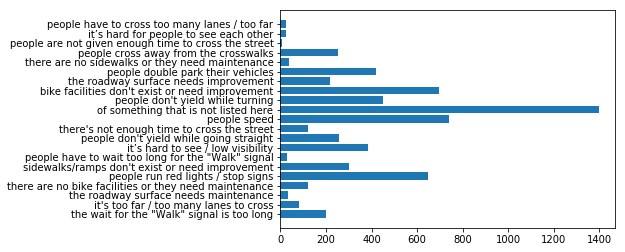

In [101]:
#Visualize the distribution of the categories after the first round of category consolidation


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [102]:
#Count how many occurrences of each category occur in the dataset
#Create a list with tuples containing each category and its number of occurrences


count = Counter(data['REQUESTTYPE'])
count = count.items()
count = list(count)
count.sort()
print(count)

print(count[14][0], count[19][0])
print(count[0][0], count[18][0])
print(count[11][0], count[17][0])
print(count[15][0], count[16][0])
print(count[2][0], count[3][0])
print(count[1][0], count[10][0])
print(count[5][0], count[20][0])


[("bike facilities don't exist or need improvement", 695), ("it's too far / too many lanes to cross", 82), ('it’s hard for people to see each other', 26), ('it’s hard to see / low visibility', 385), ('of something that is not listed here', 1400), ('people are not given enough time to cross the street', 9), ('people cross away from the crosswalks', 254), ("people don't yield while going straight", 256), ("people don't yield while turning", 451), ('people double park their vehicles', 418), ('people have to cross too many lanes / too far', 24), ('people have to wait too long for the "Walk" signal', 27), ('people run red lights / stop signs', 647), ('people speed', 741), ("sidewalks/ramps don't exist or need improvement", 299), ('the roadway surface needs improvement', 216), ('the roadway surface needs maintenance', 34), ('the wait for the "Walk" signal is too long', 198), ('there are no bike facilities or they need maintenance', 122), ('there are no sidewalks or they need maintenance', 38

In [103]:
#For each category pair, check which category appears less often
#Replace that category with the other category


#bike facilities don't exist or need improvement / there are no bike facilities or they need maintenance


if count[0][1] > count[18][1]: 
    data['REQUESTTYPE'].replace(to_replace=count[18][0], value=count[0][0], inplace=True)

elif count[18][1] > count[0][1]:
    data['REQUESTTYPE'].replace(to_replace=count[0][0], value=count[18][0], inplace=True)

    
#sidewalks/ramps don't exist or need improvement / there are no sidewalks or they need maintenance


if count[14][1] > count[19][1]:
    data['REQUESTTYPE'].replace(to_replace=count[19][0], value=count[14][0], inplace=True)
    
elif count[19][1] > count[14][1]:
    data['REQUESTTYPE'].replace(to_replace=count[14][0], value=count[19][0], inplace=True)
    
    
#people have to wait too long for the "Walk" signal / the wait for the "Walk" signal is too long


if count[11][1] > count[17][1]:
    data['REQUESTTYPE'].replace(to_replace=count[17][0], value=count[11][0], inplace=True)
    
elif count[17][1] > count[11][1]:
    data['REQUESTTYPE'].replace(to_replace=count[11][0], value=count[17][0], inplace=True)
    

#the roadway surface needs improvement / the roadway surface needs maintenance


if count[15][1] > count[16][1]:
    data['REQUESTTYPE'].replace(to_replace=count[16][0], value=count[15][0], inplace=True)
    
elif count[16][1] > count[15][1]:
    data['REQUESTTYPE'].replace(to_replace=count[15][0], value=count[16][0], inplace=True)
    
    
#it’s hard to see / low visibility / it’s hard for people to see each other


if count[2][1] > count[3][1]:
    data['REQUESTTYPE'].replace(to_replace=count[3][0], value=count[2][0], inplace=True)
    
elif count[3][1] > count[2][1]:
    data['REQUESTTYPE'].replace(to_replace=count[2][0], value=count[3][0], inplace=True)
    
    
#it's too far / too many lanes to cross / people have to cross too many lanes / too far


if count[1][1] > count[10][1]:
    data['REQUESTTYPE'].replace(to_replace=count[10][0], value=count[1][0], inplace=True)
    
elif count[10][1] > count[1][1]:
    data['REQUESTTYPE'].replace(to_replace[1][0], value=count[10][0], inplace=True)

    
#people are not given enough time to cross the street / there's not enough time to cross the street


if count[5][1] > count[20][1]:
    data['REQUESTTYPE'].replace(to_replace=count[20][0], value=count[5][0], inplace=True)
    
elif count[20][1] > count[5][1]:
    data['REQUESTTYPE'].replace(to_replace=count[5][0], value=count[20][0], inplace=True)

print(Counter(data['REQUESTTYPE']))
print(len(data['REQUESTTYPE'].unique()))


Counter({'of something that is not listed here': 1400, "bike facilities don't exist or need improvement": 817, 'people speed': 741, 'people run red lights / stop signs': 647, "people don't yield while turning": 451, 'people double park their vehicles': 418, 'it’s hard to see / low visibility': 411, "sidewalks/ramps don't exist or need improvement": 337, "people don't yield while going straight": 256, 'people cross away from the crosswalks': 254, 'the roadway surface needs improvement': 250, 'the wait for the "Walk" signal is too long': 225, "there's not enough time to cross the street": 131, "it's too far / too many lanes to cross": 106})
14


In [104]:
#Make a copy of the dataset
#Separate the features from the response variable


consolidated_data = data.copy()

target = data['REQUESTTYPE']
comments = data['COMMENTS']


["bike facilities don't exist or need improvement" 'of something that is not listed here'
 "people don't yield while going straight" 'it’s hard to see / low visibility'
 "people don't yield while turning" 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement" 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed' 'people run red lights / stop signs'
 "it's too far / too many lanes to cross" "there's not enough time to cross the street"
 'the roadway surface needs improvement']


([<matplotlib.axis.YTick at 0x26742fad6d8>,
 <a list of 14 Text yticklabel objects>)

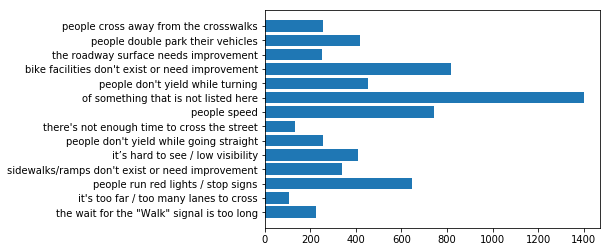

In [105]:
#Visualize the distribution of the consolidated categories


print(target.unique())
plt.barh(range(len(target.unique())), list(Counter(target).values()), align='center')
plt.yticks(range(len(target.unique())), list(Counter(target).keys()))


# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

The original selection of 28 categories have now been consolidated into the following 14:


1. "bike facilities don't exist or need improvement"

2. "of something that is not listed here"

3. "people don't yield while going straight"

4. "it’s hard to see / low visibility"

5. "people don't yield while turning"

6. "the wait for the "Walk" signal is too long"

7. "sidewalks/ramps don't exist or need improvement"

8. "people cross away from the crosswalks"

9. "people double park their vehicles"

10. "people speed"

11. "people run red lights / stop signs"

12. "it's too far / too many lanes to cross"

13. "there's not enough time to cross the street"

14. "the roadway surface needs improvement"
 
 

In [106]:
#Split the dataset into training and test sets
#Vectorize the comments


comments_train, comments_test, target_train, target_test = train_test_split(comments,
                                                                            target, stratify=target,
                                                                           random_state=3)

vect = CountVectorizer()

X_train = vect.fit_transform(comments_train)
X_test = vect.transform(comments_test)

#X_train_scaled = reg.fit_transform(X_train)
#X_test_scaled = reg.transform(X_test)


In [107]:
#Score a baseline multinomial naive Bayes model using F1-macro score


baseline = np.mean(cross_val_score(LogisticRegression(random_state=3), X_train, target_train,
                                   cv=5, scoring='f1_macro', n_jobs=8))
print('Baseline F1 Macro score:', baseline)

assert baseline > 0.5


Baseline F1 Macro score: 0.514581885128


In [108]:
#Display the confusion matrix and classification report


lr = LogisticRegression(random_state=3)
lr.fit(X_train, target_train)

np.set_printoptions(linewidth=100)

baseline_preds = cross_val_predict(lr, X_train, target_train, cv=5, n_jobs=8)

print(confusion_matrix(target_train, baseline_preds))
print(classification_report(target_train, baseline_preds))
      

[[454   3   1  78   0   1  14  16   4  16  14   9   3   0]
 [  7   6   5  26  10   3   2   0   2   7   1   3   5   2]
 [ 11   0 178  65   1   5   8   2  10  24   2   1   1   0]
 [ 85   3  40 545  42  25  56  34  74  59  50  16  12   9]
 [  2   1   1  57  85   9  11   1   4   8   7   1   1   3]
 [ 14   0  11  42   4  53  20   2  10  28   4   0   3   1]
 [ 20   0  14  79   4  20 152   2  20  17   1   2   5   2]
 [ 24   0   2  69   1   0   2 205   3   3   2   2   1   0]
 [  7   0   5  78   5  12  14   0 317  37   1   0   7   2]
 [ 23   3  19  72   2  12  13   5  34 367   3   0   2   1]
 [ 15   0   1  58  10   1   2   4   1   6 148   4   3   0]
 [ 35   0   3  36   1   1   2   5   2   2   7  92   1   0]
 [  2   0   2  37   3   1   6   0   8   2   2   0  95  11]
 [  1   1   2  26   6   2   7   0   4   6   1   0  16  26]]
                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.65      0.74      0.69     

From the confusion matrix and classification report, it appears that model is having trouble with these particular aspects of the model:

1. There are a great number of data points that are incorrectly classified as "of something that is not listed here". There are also many data points belonging to that category but incorrectly classified as other categories. Browsing through the comments belonging to "of something that is not listed here", it seems that many should belong to categories that already exist. Without having looked at the interface through which these complaints were collected, I would guess that maybe "of something that is not listed here" is the default option and many people don't bother changing it before submitting their complaints

2. The similarities between comments in the group "people don't yield while going straight", "people don't yield while turning", and "people run red lights / stop signs" are confusing the model. In the confusion matrix, it appears that a portion of the data points in each category are being mistakenly classified as other categories in this group.

3. Some data points in the "people speed" and "people run red lights / stop signs" categories are being mistakenly categorized as the other category. Similar to #1, many other data points belonging to other categories are being mistakenly categorized as one of these two categories.

4. Some data points in the group "bike facilities don't exist or need improvement", "sidewalks/ramps don't exist or need improvement", and "the roadway surface needs improvement" categories are being mistakenly categorized as other categories in this group. This seems to be due to the fact that complaints about bike facilities include those about poor road conditions or faded lane marking paint in bike lanes, which would overlap with comments about sidewalks and roadway conditions.

5. To a lesser extent than in #1, many data points are being mistakenly classified as "bike facilities don't exist or need improvement", most likely due to complaints about the bike facilities mentioning poor road conditions or danger due to traffic.


# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

I began removing stop words using CountVectorizer since I saw that it reduced the number of features while achieving the same accuracy. I then performed grid searches using the following models to see if I can get better performance:


1. Multinomial Naive Bayes
2. Logistic Regression
3. Random Forest
4. SVM


I searched over the following parameter grid for CountVectorizer():


1. 'ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7), (2, 3), (2, 5), (3, 8), (5, 5)]
2. 'analyzer': ['word', 'char', 'char_wb'],
3. 'min_df': [1, 2, 3],
4. 'normalizer': [None, Normalizer()]

Based on the results, I decided to continue with Naive Bayes and Logistic Regression since they performed well, with similar cross-validation scores using the optimal parameters. Also, these two models took much less time to run compared to random forest and SVM.


The optimal CountVectorizer() parameters to use with a Naive Bayes model were:


>{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}


The optimal CountVectorizer() parameters to use with a Logistic Regression model were:


>{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char'}


Next, I used tf-idf rescaling on these two models and found that they greatly reduced the accuracy of the model compared with CountVectorizer(). 


I also tried adding a feature indicating the length of the original comment string and found that it either improved or worsened the model by a negligible amount. Therefore I decided not to include that feature in my model.


Finally, I incorporated a lemmatization function from the spaCy package to use as a custom tokenizer for CountVectorizer(). This change slightly increased my F1 macro score.



In [109]:
#Remove stop words when vectorizing the dataset


stop = CountVectorizer(stop_words='english')

X_train = stop.fit_transform(comments_train)
X_test = stop.transform(comments_test)

lr.fit(X_train, target_train)
stop_score = cross_val_score(lr, X_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)

print('Stop Word Removal Scores:', stop_score)
print('Stop Word Removal Mean Score:', np.mean(stop_score))


Stop Word Removal Scores: [ 0.52890967  0.48834931  0.49922607  0.53828119  0.51008299]
Stop Word Removal Mean Score: 0.512969846191


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------


Best score achieved through GridSearchCV with a Multinomial Naive Bayes model:
    

>0.525103133804


Best parameters:


>{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}



In [110]:
#Grid search using a naive Bayes model to find the best model paramaters


#params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()]
#}

#nb_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                  Normalizer(), MultinomialNB()) ,
#                    param_grid=params, cv=5, scoring='f1_macro', n_jobs=8)

#nb_grid.fit(comments_train, target_train)
#print(nb_grid.best_score_)
#print(nb_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a logistic regression model:


>0.544554548341


Best parameters:


>{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char', 'C': 0.1}




In [111]:
#Grid search using a logistic regression model to find the best model paramaters


#lr_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'logisticregression__C': [100, 10, 1, 0.1, 0.01]
#        }

#lr_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), LogisticRegression()), 
#                       param_grid=lr_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=2)

#lr_grid.fit(comments_train, target_train)
#print(lr_grid.best_score_)
#print(lr_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a random forest model:


>0.505797024798


Best parameters:


>{'normalizer': None, 'n_estimators': 200, 'ngram_range': (5, 5), 'analyzer': 'char', 'min_df': 3}



In [112]:
#Grid search using a random forest model to find the best model parameters


#rf_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#             'randomforestclassifier__n_estimators': [50, 100, 150, 200],
#        }

#rf_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), RandomForestClassifier()),
#                      param_grid=rf_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=3)

#rf_grid.fit(comments_train, target_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with an SVM model:


> 0.533144313588


Best parameters:


> {normalizer': None, 'min_df': 3, 'analyzer': 'char', 'ngram_range': (2, 5), 'C': 100}



In [113]:
#Grid search using an SVM model to find the best model parameters


#sv_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'svc__C': [100, 10, 1, 0.1, 0.01]
#        }

#sv_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                     Normalizer(), SVC()),
#                                    param_grid=sv_params, cv=5, scoring='f1_macro', verbose=2)

#sv_grid.fit(comments_train, target_train)
#print(sv_grid.best_score_)
#print(sv_grid.best_params_)


In [114]:
#Compare tf-idf rescaling with CountVectorizer using the best Logistic Regression model parameters
#{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char', 'C': 0.1}


tf_lr_pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(3, 8),
                                           min_df=2, analyzer='char'),LogisticRegression(C=0.1))

cv_lr_pipe = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(3, 8), 
                                           min_df=2, analyzer='char'), LogisticRegression(C=0.1))

tf_lr_pipe.fit(comments_train, target_train)
cv_lr_pipe.fit(comments_train, target_train)

tf_score = cross_val_score(tf_lr_pipe, comments_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)
cv_score = cross_val_score(cv_lr_pipe, comments_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)

print('tfidf scores:', tf_score)
print('tfidf mean score', np.mean(tf_score))
print('CountVectorizer scores', cv_score)
print('CountVectorizer mean score', np.mean(cv_score))


tfidf scores: [ 0.09081819  0.0896437   0.08717221  0.08955632  0.10823895]
tfidf mean score 0.0930858747552
CountVectorizer scores [ 0.54406666  0.51813003  0.53888965  0.54986739  0.53157476]
CountVectorizer mean score 0.536505698152


In [115]:
#Compare tf-idf rescaling with CountVectorizer using the best Naive Bayes model parameters
#{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}


tf_nb_pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(2, 5), 
                                           min_df=3, analyzer='char_wb'), MultinomialNB())

cv_nb_pipe = make_pipeline(CountVectorizer(stop_words='engish', ngram_range=(2, 5),
                                          min_df=3, analyzer='char_wb'), MultinomialNB())

print('tfidf:',
      cross_val_score(tf_nb_pipe, comments_train, target_train,
                      cv=5, scoring='f1_macro', n_jobs=8))
print('CountVectorizer',
     cross_val_score(cv_nb_pipe, comments_train, target_train,
                     cv=5, scoring='f1_macro', n_jobs=8))


tfidf: [ 0.1217809   0.13018391  0.11988127  0.10391956  0.11592905]
CountVectorizer [ 0.5326411   0.53283782  0.52351483  0.50213999  0.53429213]


In [116]:
#Add feature that indicates the length of the original comment string
#Evaluate this model using Naive Bayes


nb_cv = CountVectorizer(stop_words='english', ngram_range=(2, 5),
                       min_df=3, analyzer='char_wb')

train_len = comments_train.str.len()
train_len = np.reshape(train_len, (4833, 1))


comments_len = nb_cv.fit_transform(comments_train)
comments_len = hstack((comments_len, train_len))

nb_score = cross_val_score(MultinomialNB(), comments_len, target_train, cv=5,
                           scoring='f1_macro', n_jobs=8)

print('nb scores:', nb_score)
print('nb mean score:', np.mean(nb_score))


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


nb scores: [ 0.51692009  0.51441714  0.50502863  0.48843074  0.53145467]
nb mean score: 0.511250254695


In [117]:
#Evaluate this model using Logistic Regression


lr_cv = CountVectorizer(stop_words='english', ngram_range=(3, 8),
                       min_df=2, analyzer='char')

comments_len = lr_cv.fit_transform(comments_train)
comments_len = hstack((comments_len, train_len))

lr_score = cross_val_score(LogisticRegression(C=0.1), comments_len, target_train, cv=5,
                           scoring='f1_macro', n_jobs=8)

print('LR scores:', lr_score)      
print('LR mean score:', np.mean(lr_score))     


LR scores: [ 0.55055735  0.5150431   0.53707717  0.55339255  0.52731333]
LR mean score: 0.536676700182


In [118]:
#Implement a custom tokenizer that uses spaCy to perform lemmatization on the comments first


regexp = re.compile('(?u)\\b\\w\\w+\\b')
en_nlp = spacy.load('en_default')

old_tokenizer = en_nlp.tokenizer

en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
regexp.findall(string))

def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False)
    
    return [token.lemma_ for token in doc_spacy]


In [119]:
#Evaluate this model using Logistic Regression


lr_lemma_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                            ngram_range=(3, 8), min_df=2, analyzer='char'), LogisticRegression(C=0.1))

lr_lemma_pipe.fit(comments_train, target_train)
lr_lemma_score = cross_val_score(lr_lemma_pipe, comments_train, target_train, cv=5,
                                scoring='f1_macro')

print('LR Lemmatization Scores:', lr_lemma_score)
print('LR Lemmatization Mean Score:', np.mean(lr_lemma_score))


LR Lemmatization Scores: [ 0.54406666  0.51813003  0.53888965  0.54986739  0.53157476]
LR Lemmatization Mean Score: 0.536505698152


In [120]:
#Evaluate this model using Naive Bayes


nb_lemma_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                                              ngram_range=(2, 5), min_df=3, analyzer='char_wb'),
                             MultinomialNB())

nb_lemma_pipe.fit(comments_train, target_train)
nb_lemma_score = cross_val_score(nb_lemma_pipe, comments_train, target_train, cv=5,
                                scoring='f1_macro')

print('NB Lemmatization Scores:', nb_lemma_score)
print('NB Lemmatization Mean Score:', np.mean(nb_lemma_score))


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NB Lemmatization Scores: [ 0.5326411   0.53283782  0.52351483  0.50213999  0.53429213]
NB Lemmatization Mean Score: 0.525085174088


This section has been commented out to due to not being able to upload the Google News vector file to GitHub
-----------------------------------------------------------------------------------------------------------


In this section, I tried emulating the method that was demonstrated in class for transforming documents using gensim and word2vec. I transformed the comments in this manner and performed logistic regression on the transformed text. The results were extremely poor compared to the other models that I tried thus far, with a mean cross-validation score of 0.04. Therefore I decided not to continue experimenting with it.



In [161]:
#Transform the dataset comments using gensim


#gen_comments = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
#                            ngram_range=(3, 8), min_df=2, analyzer='char').fit_transform(comments)

#texts = [[token for token in comment.lower().split()] for comment in comments]

#dictionary = corpora.Dictionary(texts)

#corpus = [dictionary.doc2bow(text) for text in texts]
#sparse_corpus = gensim.matutils.Sparse2Corpus(gen_comments.T)


In [156]:
#Load the Google News vector file


#words = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


In [159]:
#vect_words = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
#                            ngram_range=(3, 8), min_df=2, analyzer='char',
#                            vocabulary=words.index2word)
                                                                   
#vect_words.fit(comments_train)
#docs = vect_words.inverse_transform(vect_words.transform(comments_train))

#X_w2v_train = np.vstack([np.mean(words[doc], axis=0) for doc in docs])

#w2v_test = vect_words.inverse_transform(vect_words.transform(comments_test))
#X_w2v_test = np.vstack([np.mean(words[doc], axis=0) for doc in w2v_test])


In [160]:
#Perform logistic regression using the word2vec model and the optimal value for the parameter C


#lr_w2v = LogisticRegression(C=0.1).fit(X_w2v_train, target_train)

#lr_w2v_score = cross_val_score(lr_w2v, X_w2v_train, target_train, cv=5,
#                                scoring='f1_macro')

#print('LR word2vec Scores:', lr_w2v_score)
#print('LR word2vec Mean Score:', np.mean(lr_w2v_score))


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is il

LR word2vec Scores: [ 0.0385147   0.04313065  0.04022314  0.03926321  0.0393303 ]
LR word2vec Mean Score: 0.0400923990239


# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

Since the Logistic Regression model consistently performed better than the Naive Bayes model, I decided to use that along with lemmatization going forward.


Though the accuracy is slightly improved, this model is still making classification mistakes that are similar in nature to the ones made by the baseline model.



In [121]:
#Score the tuned model on the training set
#Print the confusion matrix and classification report


preds = cross_val_predict(lr_lemma_pipe, comments_train, target_train, cv=5)

print(confusion_matrix(target_train, preds))
print(classification_report(target_train, preds))


[[466   2   1  82   1   2  12  10   2  14   8  13   0   0]
 [  2   5   3  30   7   5   3   0   2   6   5   1   6   4]
 [  7   0 182  70   2   2  11   1   9  20   3   1   0   0]
 [ 82   0  44 575  35  29  46  28  76  64  43  10  12   6]
 [  3   0   4  59  89   4   6   2   0  12   7   1   1   3]
 [ 10   0   8  54   6  58  18   2   9  22   3   0   2   0]
 [ 17   0  12  81   3  16 153   2  27  19   2   0   3   3]
 [ 17   0   7  51   0   0   1 227   3   3   0   5   0   0]
 [  7   0   3  84   4  10  19   1 317  33   1   0   4   2]
 [ 20   2  17  72   1  10  11   3  27 387   3   1   2   0]
 [ 12   0   3  56  15   0   0   1   2  12 146   3   2   1]
 [ 32   0   0  38   2   1   2   2   1   0   8 100   1   0]
 [  3   0   3  31   4   0   3   1  10   4   4   1  94  11]
 [  0   2   2  25   6   0   5   0   7   6   0   0  16  29]]
                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.69      0.76      0.72     

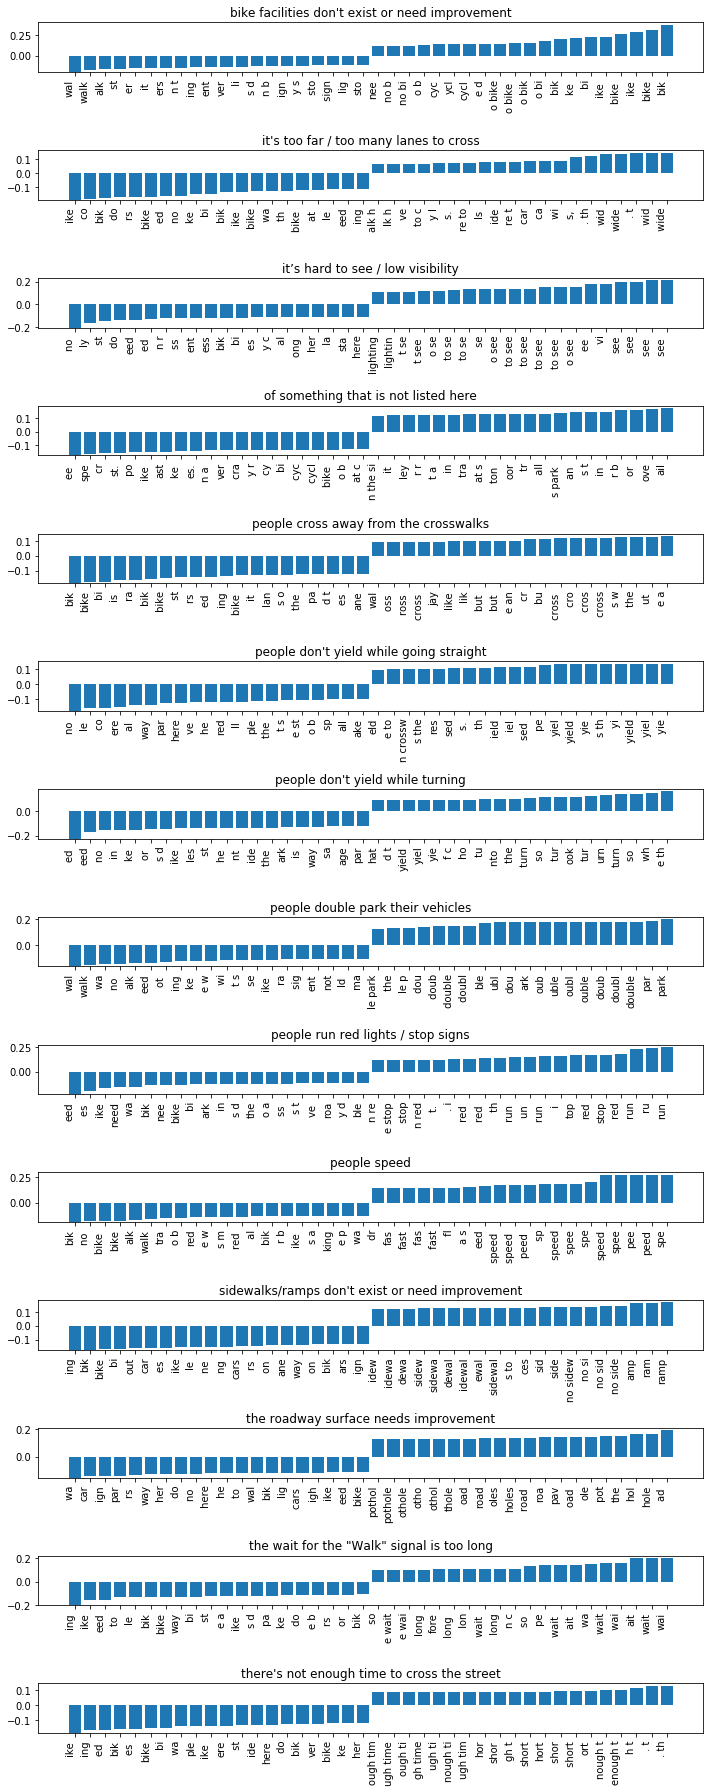

In [122]:
#Plot the most important character n-grams for each category


feature_names = lr_lemma_pipe.named_steps['countvectorizer'].get_feature_names()

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=90, ha='right')

n_classes = len(lr_lemma_pipe.classes_)

fig, axes = plt.subplots(n_classes, figsize=(10, 25))

for ax, coef, label in zip(axes.ravel(),
                           lr_lemma_pipe.named_steps['logisticregression'].coef_,
                          lr_lemma_pipe.classes_):

    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), top_n=20, ax=ax)
    
plt.tight_layout()
    

In [123]:
#Filter out the misclassified comments and show some examples


misclassified = np.stack((np.array(comments_train), np.array(target_train), preds), axis=-1)
misclassified = misclassified[misclassified[:, 1] != misclassified[:, 2]]


for complaint in range(0, 2000, 400):
    print('\n', misclassified[complaint, 0], '\n',
          '\n', 'true category:', misclassified[complaint, 1],
          '\n', 'misclassified as:', misclassified[complaint, 2])



 Poor markings. Poor visibility. No bike infra. Poor ped infra. Speeding. Too many games of chicken. I've had numerous close calls on bike and driving here. 
 
 true category: of something that is not listed here 
 misclassified as: bike facilities don't exist or need improvement

 This road needs to be repaved. Very dangerous as a biker since the road is so uneven and there are no bike lanes ANYWHERE! 
 
 true category: the roadway surface needs improvement 
 misclassified as: bike facilities don't exist or need improvement

 I've been almost hit many times here. Pedestrians are not very visible to cars turning left from Stoughton and right from Dudley. No turns on red please! Bulbs outs would be great, too! 
 
 true category: people don't yield while turning 
 misclassified as: of something that is not listed here

 Pedestrians cross the eastbound Commonwealth Ave lanes while cars are making U turns from westbound to eastbound Commonwealth Ave.  The light is short so cars rush throu

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

I performed grid searches in the range of 3-20 topics/clusters for K-Means, LDA, and NMF. Judging from samples of the comments belonging to each cluster in each iteration, I found that the optimal number of clusters for K-Means was 13. The following are the 13 topic labels that I decided on based on the outputted comments:


1. Unsafe conditions for bicyclists (cluster with only one comment)
2. Problems due to parking
3. Unsafe conditions for pedestrians
4. Need bicycle lanes
5. Traffic problems caused by cars turning at intersections or changing lanes
6. People speed
7. Bicycle lanes need improvement
8. Unsafe conditions when performing left turns
9. Unsafe conditions for bicyclists (cluster with only one comment)
10. Miscellaneous (a vague complaint, complaint about not mentioned elsewhere, or acomplaint about several topics)
11. Need to wait too long for a walk signal, not enough time to cross, or no crosswalk available, or pedestrians jaywalking
12. Miscellaneous (a vague complaint, complaint about not mentioned elsewhere, or acomplaint about several topics)
13. Unsafe conditions for bicyclists


Several of theese clusters can be consolidated, especially the miscellaneous and single comment clusters.


LDA produced abstract topics that could be interpreted more generally. I found that the optimal number of clusters for LDA was 4. With 5 or more comments, I observed that these abstract topics would begin appearing multiple times. The following are the 4 topic labels that I decided on based on the outputted feature words:


1. Traffic problems at intersections
2. Unsafe conditions for bicyclists
3. Unsafe conditions for pedestrians
4. Problems due to parking


The topics found by NMF were similar in nature to those found by LDA and were even outputted in the same order, except that importance of individual feature words differed within each topic.


In general, the ARI between the topics/clusters produced by each algorithm and the original assigned categories are very low, especially for K-Means and LDA, which never achieved an ARI greater than 0.1. NMF did better, although it still never achieved an ARI greater than 0.15.


K-Means was able to produce clusters that could be matched to some of the ground truth labels:


1. Unsafe conditions for bicyclists / "bike facilities don't exist or need improvement"
2. Problems due to parking / "people double park their vehicles"
3. Unsafe conditions for pedestrians / "people run red lights / stop signs"
4. Need bicycle lanes / "bike facilities don't exist or need improvement"
5. Traffic problems caused by cars turning at intersections or changing lanes / "people don't yield while turning"
6. People speed / "people speed"
7. Bicycle lanes need improvement / "bike facilities don't exist or need improvement"
8. Miscellaneous / "of something that is not listed here"



In [124]:
#Vectorize the comments with an n-gram range of 1-4
#Perform a grid search to find the most sensible number of clusters for K-Means clustering 
#Calculate the ARI for each iteration (from 3 to 20 clusters)
#Print the first 5 comments in each cluster


cv = CountVectorizer(min_df=2, ngram_range=(1, 4), analyzer='word', stop_words='english')
vec_comments = cv.fit_transform(comments)
feature_names = cv.get_feature_names()

km_ari = np.zeros((18,))

for n_cluster in range(18):
    km = KMeans(n_clusters=n_cluster+3, n_jobs=8, random_state=3)
    vec_comments = cv.fit_transform(comments)
    km.fit(vec_comments)
    km_preds = km.predict(vec_comments)
    
    km_ari[n_cluster] = adjusted_rand_score(target, km_preds)
    
    print(n_cluster+3, 'bin count', np.bincount(km_preds))
    km_clusters = np.stack((np.array(comments), km_preds), axis=-1)

    for cluster in range(n_cluster+3):
        try:
            print('number of clusters', n_cluster+3, 'cluster #', cluster, '\n', 
                  km_clusters[km_clusters[:, 1] == cluster][0:5, 0], '\n')
        except: continue


3 bin count [ 683 1448 4313]
number of clusters 3 cluster # 0 
 [ "This intersection is dangerous. Cars don't follow the lane markings (ie go straight while in turn lane) so it's nearly impossible to safely position yourself on a bike. In a car, people are trying to move over/it's unclear where people are going."
 'People turn from both the middle lane (not a turn lane) and from the actual turn lane. Just yesterday saw two cars in a row do it and almost witnessed a car accidents and walkers be hit.'
 'Cars FREQUENTLY turn right onto Bay State road from the left lane on Carlton'
 'The bike lane markings have worn away'
 'There are four lanes here. One is a left turn only. The other three try to merge into one. Making the rightmost lane right turn only & painting a bike lane would help.  Maybe a bike only signal to give cyclists a headstart to clear the intersection'] 

number of clusters 3 cluster # 1 
 [ "It's terrifying to walk over here. It seems like it's impossible to get the cars 

In [125]:
#Print the most important words in each of the topics found by LDA or NMF


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

In [126]:
#Vectorize the comments into unigrams
#Perform a grid search to find the most sensible number of topics for LDA
#Calculate the ARI for each iteration
#Print the top 20 feature words in each topic

    
uni_cv = CountVectorizer(min_df=2, ngram_range=(1, 1), analyzer='word', stop_words='english')
uni_vec_comments = uni_cv.fit_transform(comments)
feature_names = uni_cv.get_feature_names()

lda_ari = np.zeros((18,))

for topics in range(18):
    lda = LatentDirichletAllocation(n_topics=topics+3, learning_method='batch', n_jobs=8, random_state=3)
    lda.fit(uni_vec_comments)
    lda_clusters = np.argmax(lda.transform(uni_vec_comments), axis=1)
    ari = adjusted_rand_score(target, lda_clusters)
    lda_ari[topics] = ari
    print('number of topics:', topics+3)
    print_top_words(lda, feature_names, 20)


number of topics: 3
Topic #0:
light walk cross red people street signal pedestrians cars lights intersection traffic speed crossing time run crosswalk green pedestrian drivers
Topic #1:
bike lane lanes cars traffic right road left people parking turn street sidewalk bikes dangerous park double need needs path
Topic #2:
cars street people stop st traffic pedestrians drivers way intersection ave sign turn left yield crosswalk turning speed don dangerous

number of topics: 4
Topic #0:
light walk cross red signal pedestrians lights people intersection cars traffic crossing crosswalk green time run pedestrian long turn drivers
Topic #1:
bike lane lanes right traffic cars road bikes left people parking park street dangerous double turn need sidewalk way path
Topic #2:
stop cars people pedestrians street drivers st sign way intersection crosswalk yield traffic ave don turning right crossing coming corner
Topic #3:
street cars speed people traffic turn left road st dangerous drivers parking ar

In [127]:
#Vectorize the comments into unigrams
#Scale the data
#Perform a grid search to find the most sensible number of components for NMF
#Calculate the ARI for each iteration
#Print the top 20 feature words in each topic


scaler = MaxAbsScaler()
scaled_uni_vec = scaler.fit_transform(uni_vec_comments)

nmf_ari = np.zeros((18,))

for topics in range(18):
    nmf = NMF(n_components=topics+3, tol=0.1, random_state=3)
    nmf.fit(scaled_uni_vec)
    nmf_clusters = np.argmax(nmf.transform(scaled_uni_vec), axis=1)
    ari = adjusted_rand_score(target, nmf_clusters)
    nmf_ari[topics] = ari
    print('number of topics:', topics+3)
    print_top_words(nmf, feature_names, 20)



number of topics: 3
Topic #0:
cross walk intersection pedestrians light cars stop traffic people pedestrian crossing street sign red crosswalk dangerous time lights long run
Topic #1:
bike lane cars double parked road lanes traffic parking park needs stretch dangerous make right facilities ave people narrow street
Topic #2:
turning yield don cars right pedestrians left drivers turn coming sign difficult turns green ave going bikes crosswalk fail hit

number of topics: 4
Topic #0:
cross walk pedestrians light intersection pedestrian traffic crossing red stop people long sign time lights crosswalk run wait drivers don
Topic #1:
bike lane lanes needs facilities stretch right ave road traffic make turn left cyclists dangerous need protected bikes separated path
Topic #2:
turning yield don cars right pedestrians left drivers turn sign turns coming difficult green going bikes fail ave straight crosswalk
Topic #3:
cars parked double street park people seen parking speed corner road traffic li

In [128]:
#Show the ARI for each iteration of each clustering method


print('K-Means ARI:', km_ari)
print('LDA ARI:', lda_ari)
print('NMF ARI:', nmf_ari)


K-Means ARI: [ 0.0034333   0.00979347  0.00974627  0.01300254  0.01287464  0.03415864  0.03950653  0.04678254
  0.03244342  0.03634926  0.03289181  0.03292393  0.03475261  0.03311317  0.03712333  0.0282325
  0.03036312  0.05522146]
LDA ARI: [ 0.07946476  0.09612949  0.08766042  0.09386184  0.09112169  0.09708724  0.09343576  0.09182676
  0.0927005   0.09229572  0.09355829  0.08828602  0.0859475   0.07541112  0.08136874  0.07556749
  0.07852524  0.09270562]
NMF ARI: [ 0.0735387   0.10116714  0.10188252  0.10615778  0.10329096  0.12447399  0.12686846  0.11654513
  0.12398981  0.11116636  0.12051457  0.11582167  0.10285854  0.09399581  0.11420386  0.08794528
  0.08981818  0.08821325]


# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


Using the same 4 topic NMF clustering method, I was able to achieve a test F1-macro score of 0.852.
---------------------------------------------------------------------------------------------------


Before reassigning labels using K-Means, I further consolidated the 13 clusters to the following set of categories:


1. Problems due to parking
2. Unsafe conditions for pedestrians
3. Need bicycle lanes
4. Traffic problems caused by cars turning at intersections or changing lanes
5. People speed
6. Bicycle lanes need improvement
7. Unsafe conditions when performing left turns
8. Miscellaneous (a vague complaint, complaint about not mentioned elsewhere, or acomplaint about several topics)
9. Need to wait too long for a walk signal, not enough time to cross, or no crosswalk available, or pedestrians jaywalking
10. Unsafe conditions for bicyclists


With the K-Means label reassignment, I was able to achieve the following results:


> K-Means Test Scores: [ 0.81083396  0.78832353  0.79341047  0.79782964  0.77890906]


> K-Means Mean Test Score: 0.793861330958


> K-Means Test Score: 0.813732545579


With the LDA label reassignment, I was able to achieve the following results:


> LDA Test Scores: [ 0.78769413  0.76823181  0.77187473  0.76537267  0.76632631]


> LDA Mean Test Score: 0.771899929594


> LDA Test Score: 0.795662381271


With the NMF label reassignment, I was able ot achieve the following results:


> NMF Training Scores: [ 0.85310959  0.86510815  0.85713618  0.88016126  0.82408769]


> NMF Mean Training Score: 0.855920575133


> NMF Test Score: 0.851995099133



In [129]:
#Reassign labels using K-Means with 13 clusters
#Further consolidate the clusters
#Split the dataset with the new labels into training and test sets


km = KMeans(n_clusters=13, n_jobs=8, random_state=3)
vec_comments = cv.fit_transform(comments)
km.fit(vec_comments)
km_preds = km.predict(vec_comments)

km_preds[km_preds == 0] = 12
km_preds[km_preds == 8] = 12
km_preds[km_preds == 11] = 9

X_km_train, X_km_test, y_km_train, y_km_test = train_test_split(comments,
                                                                km_preds, stratify=km_preds, random_state=3)


In [130]:
#Perform logistic regression using the new categories obtained through K-Means Clustering


lr_lemma_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                            ngram_range=(3, 8), min_df=2, analyzer='char'), LogisticRegression(C=0.1))

lr_lemma_pipe.fit(X_km_train, y_km_train)
km_cv_score = cross_val_score(lr_lemma_pipe, X_km_train, y_km_train, cv=5,
                                scoring='f1_macro')

km_score = f1_score(y_km_test,lr_lemma_pipe.predict(X_km_test), average='macro')

print('LR K-Means Training Scores:', km_cv_score)
print('LR K-Means Mean Training Score:', np.mean(km_cv_score))
print('LR K-Means Test Score:', km_score)


LR K-Means Training Scores: [ 0.85204969  0.81562418  0.80870576  0.84856425  0.79881984]
LR K-Means Mean Training Score: 0.824752742634
LR K-Means Test Score: 0.804294034372


In [131]:
#Reassign labels using LDA with 4 topics
#Split the dataset with the new labels into training and test sets


lda = LatentDirichletAllocation(n_topics=4, learning_method='batch', n_jobs=8, random_state=3)

lda.fit(uni_vec_comments)
lda_clusters = np.argmax(lda.transform(uni_vec_comments), axis=1)

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(comments,
                                                                    lda_clusters, stratify=lda_clusters, random_state=3)


In [132]:
#Perform logistic regression using the new categories obtained through LDA


lr_lemma_pipe.fit(X_lda_train, y_lda_train)
lda_cv_score = cross_val_score(lr_lemma_pipe, X_lda_train, y_lda_train, cv=5,
                                scoring='f1_macro')

lda_score = f1_score(y_lda_test,lr_lemma_pipe.predict(X_lda_test), average='macro')
                                    
print('LR LDA Training Scores:', lda_cv_score)
print('LR LDA Mean Training Score:', np.mean(lda_cv_score))
print('LR LDA Test Score:', lda_score)


LR LDA Training Scores: [ 0.78769413  0.76823181  0.77187473  0.76537267  0.76632631]
LR LDA Mean Training Score: 0.771899929594
LR LDA Test Score: 0.795662381271


In [133]:
#Reassign labels using NMF with 4 topics
#Split the dataset with the new labels into training and test sets


lr_nmf_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                            ngram_range=(3, 8), min_df=2, analyzer='char'), scaler, LogisticRegression(C=0.1))

nmf = NMF(n_components=4, tol=0.1, random_state=3)

nmf.fit(scaled_uni_vec)
nmf_clusters = np.argmax(nmf.transform(scaled_uni_vec), axis=1)

X_nmf_train, X_nmf_test, y_nmf_train, y_nmf_test = train_test_split(comments,
                                                                    nmf_clusters, stratify=nmf_clusters, random_state=3)


In [134]:
#Perform logistic regression using the new categories obtained through NMF


lr_nmf_pipe.fit(X_nmf_train, y_nmf_train)
nmf_cv_score = cross_val_score(lr_nmf_pipe, X_nmf_train, y_nmf_train, cv=5,
                                scoring='f1_macro')

nmf_score = f1_score(y_nmf_test,lr_nmf_pipe.predict(X_nmf_test), average='macro')

                                    
print('LR NMF Training Scores:', nmf_cv_score)
print('LR NMF Mean Training Score:', np.mean(nmf_cv_score))
print('LR NMF Test Score:', nmf_score)


LR NMF Training Scores: [ 0.85310959  0.86510815  0.85713618  0.88016126  0.82408769]
LR NMF Mean Training Score: 0.855920575133
LR NMF Test Score: 0.851995099133


I isolated the comments categorized as "of something that is not listed here" in the dataset and applied the three clustering methods using the same parameters as the models used above.


With K-Means clustering with 13 clusters, most of the categories correspond with several that were previously found from clustering the entire dataset, including general problems involving intersections and unsafe conditions for pedestrians and bicyclists. Also, there were still several clusters that seemed to contain comments that should belong to other categories.


Some new clusters that I found pertained to unsafe conditions involving one-way streets and left turn lanes or cars making left turns. It could be helpful to add these two categories as options that people can choose when making complaints.


Using LDA and NMF with 4 topics was not helpful when applied to this isolated dataset. These methods seem to have picked up on problems occurring on indidual streets (judging from the abundance of names in each topic). Such complaints most likely should belong to already existing categories rather than some new category.



In [135]:
#Isolate the data points categorized as "other" in the original dataset


other = data[data['REQUESTTYPE'] == 'of something that is not listed here']
other_comments = other['COMMENTS']
other_target = other['REQUESTTYPE']

vec_other = cv.fit_transform(other_comments)


In [136]:
#Perform K-Means on the comments categorized as "other"


km.fit(vec_other)
km_preds = km.predict(vec_other)
    
print('13 bin count', np.bincount(km_preds))
km_clusters = np.stack((np.array(other_comments), km_preds), axis=-1)

for cluster in range(13):
    try:
        print('number of clusters 13', 'cluster #', cluster, '\n', 
                km_clusters[km_clusters[:, 1] == cluster][0:5, 0], '\n')
    except: continue


13 bin count [128   9  86   1  24  50   7 158   5 745  14  96  77]
number of clusters 13 cluster # 0 
 ['People zoom down the wrong way on a ONE WAY street.'
 'This is a ONE WAY STREET that, during rush hour, drivers disobey signage and use it for two-way traffic to avoid American Legion Hwy. This is dangerous and the street (Paine St) could use more signage indicating that it is a one-way.'
 'Drivers routinely drive the wrong way down the one way street. Cars are often parked in the wrong direction.'
 'No good way to turn left onto the Southwest Corridor Inbound from Tremont Street'
 "This street is very narrow and on a one-way downhill but there's no winter parking ban. This creates a very dangerous situation in the snowy season and many parked cars have been hit."] 

number of clusters 13 cluster # 1 
 [ "All of Mass Ave needs to be redesigned.  it's a major bike route.  needs to be upgraded to current mass dot standard for separated bike facilities. no excuses."
 "The bike path is 

In [137]:
#Perform LDA on the comments categorized as "other"

uni_vec_other = uni_cv.fit_transform(other_comments)

lda = LatentDirichletAllocation(n_topics=4, learning_method='batch', n_jobs=8, random_state=3)
lda.fit(uni_vec_other)

print_top_words(lda, feature_names, 20)


Topic #0:
head forbes ashmont divided herb flexiposts brooklyn directions entirety cost congestion ditson fairmount directing focused failure biggest berkeley block hardly
Topic #1:
glen cost gridlock alford flexiposts activity coordinate focused apply directing church fairmount ashmont elder divided brookside block directions definitely crowds
Topic #2:
contributes coordinate gridlock entering control ashmont divided glen footbridge forbes alford congestion brookside entirety activity appreciate grocery flexiposts chinatown fall
Topic #3:
glen ditson congestion bicyclists hardly couldn bikelane fallen divided focused cost brookside ashmont block district biggest forbes flexiposts biker brien



In [138]:
#Perform NMF on the comments categorized as "other"


scaled_other = scaler.fit_transform(uni_vec_other)
nmf = NMF(n_components=4, tol=0.1, random_state=3)
nmf.fit(scaled_other)

print_top_words(nmf, feature_names, 20)


Topic #0:
contributes ashmont gridlock entering coordinate control glen activity congestion aiming deficient grocery block footbridge 311 alford course adults curb greenough
Topic #1:
biggest district cost ditson everybody haphazard bicyclists carries congestion accommodate hardly headphones cycletracks blossom glen elder grocery fatality amazing bikelane
Topic #2:
directing directions forbes crucial cruise ashmont begging divided boylston awesome everyday block failure absurdly happening boxes commuters head failing death
Topic #3:
hills ashmont ditson brien bikelane bay fallen focused boynton bicyclists finally fairmount divided careless garden easy buttonwood block congestion curve



In [139]:
#Test that the highest test F1-macro score achieved across all clustering methods is at least 0.8


final_scores = [km_score, lda_score, nmf_score]

assert max(final_scores) > 0.8


# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

I experimented with a model using word2vec in step 3.

